# ga code:

Iteration 0: Best Cost = 34.39484271539543
Iteration 1: Best Cost = 21.358973212794787
Iteration 2: Best Cost = 21.358973212794787
Iteration 3: Best Cost = 18.579495330239652
Iteration 4: Best Cost = 18.579495330239652
Iteration 5: Best Cost = 18.579495330239652
Iteration 6: Best Cost = 18.13623445703731
Iteration 7: Best Cost = 17.949850573925108
Iteration 8: Best Cost = 17.80290128166863
Iteration 9: Best Cost = 17.31304288188118
Iteration 10: Best Cost = 17.31304288188118
Iteration 11: Best Cost = 16.924903256571525
Iteration 12: Best Cost = 16.900505947729624
Iteration 13: Best Cost = 16.8801384824312
Iteration 14: Best Cost = 16.8801384824312
Iteration 15: Best Cost = 16.83981111703476
Iteration 16: Best Cost = 16.83981111703476
Iteration 17: Best Cost = 16.550170542245418
Iteration 18: Best Cost = 16.513199049053792
Iteration 19: Best Cost = 16.507700992967454
Iteration 20: Best Cost = 16.37251467429983
Iteration 21: Best Cost = 16.37251467429983
Iteration 22: Best Cost = 16.2887

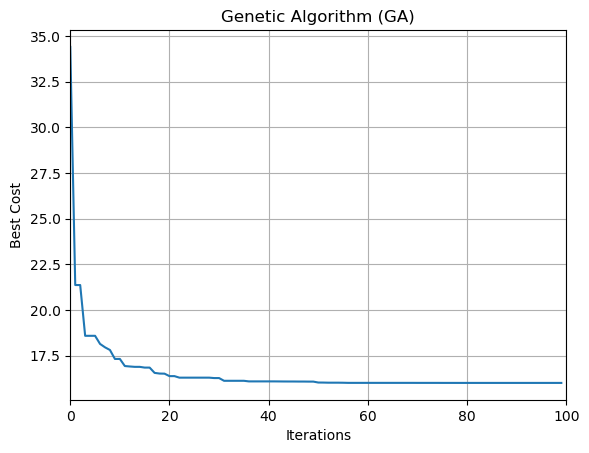

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from ypstruct import structure
import ga

# Sphere Test Function
def sphere(x):
    return sum(x**2)

# Problem Definition
problem = structure()
problem.costfunc = sphere
problem.nvar = 5
problem.varmin = [-10, -10, -1, -5,  4]
problem.varmax = [ 10,  10,  1,  5, 10]

# GA Parameters
params = structure()
params.maxit = 100
params.npop = 50
params.beta = 1
params.pc = 1
params.gamma = 0.1
params.mu = 0.01
params.sigma = 0.1

# Run GA
out = ga.run(problem, params)

# Results
plt.plot(out.bestcost)
# plt.semilogy(out.bestcost)
plt.xlim(0, params.maxit)
plt.xlabel('Iterations')
plt.ylabel('Best Cost')
plt.title('Genetic Algorithm (GA)')
plt.grid(True)
plt.show()



#  app code:

In [2]:
import numpy as np
from ypstruct import structure

def run(problem, params):
    
    # Problem Information
    costfunc = problem.costfunc
    nvar = problem.nvar
    varmin = problem.varmin
    varmax = problem.varmax

    # Parameters
    maxit = params.maxit
    npop = params.npop
    beta = params.beta
    pc = params.pc
    nc = int(np.round(pc*npop/2)*2)
    gamma = params.gamma
    mu = params.mu
    sigma = params.sigma

    # Empty Individual Template
    empty_individual = structure()
    empty_individual.position = None
    empty_individual.cost = None

    # Best Solution Ever Found
    bestsol = empty_individual.deepcopy()
    bestsol.cost = np.inf

    # Initialize Population
    pop = empty_individual.repeat(npop)
    for i in range(npop):
        pop[i].position = np.random.uniform(varmin, varmax, nvar)
        pop[i].cost = costfunc(pop[i].position)
        if pop[i].cost < bestsol.cost:
            bestsol = pop[i].deepcopy()

    # Best Cost of Iterations
    bestcost = np.empty(maxit)
    
    # Main Loop
    for it in range(maxit):

        costs = np.array([x.cost for x in pop])
        avg_cost = np.mean(costs)
        if avg_cost != 0:
            costs = costs/avg_cost
        probs = np.exp(-beta*costs)

        popc = []
        for _ in range(nc//2):

            # Select Parents
            #q = np.random.permutation(npop)
            #p1 = pop[q[0]]
            #p2 = pop[q[1]]

            # Perform Roulette Wheel Selection
            p1 = pop[roulette_wheel_selection(probs)]
            p2 = pop[roulette_wheel_selection(probs)]
            
            # Perform Crossover
            c1, c2 = crossover(p1, p2, gamma)

            # Perform Mutation
            c1 = mutate(c1, mu, sigma)
            c2 = mutate(c2, mu, sigma)

            # Apply Bounds
            apply_bound(c1, varmin, varmax)
            apply_bound(c2, varmin, varmax)

            # Evaluate First Offspring
            c1.cost = costfunc(c1.position)
            if c1.cost < bestsol.cost:
                bestsol = c1.deepcopy()

            # Evaluate Second Offspring
            c2.cost = costfunc(c2.position)
            if c2.cost < bestsol.cost:
                bestsol = c2.deepcopy()

            # Add Offsprings to popc
            popc.append(c1)
            popc.append(c2)
        

        # Merge, Sort and Select
        pop += popc
        pop = sorted(pop, key=lambda x: x.cost)
        pop = pop[0:npop]

        # Store Best Cost
        bestcost[it] = bestsol.cost

        # Show Iteration Information
        print("Iteration {}: Best Cost = {}".format(it, bestcost[it]))

    # Output
    out = structure()
    out.pop = pop
    out.bestsol = bestsol
    out.bestcost = bestcost
    return out

def crossover(p1, p2, gamma=0.1):
    c1 = p1.deepcopy()
    c2 = p1.deepcopy()
    alpha = np.random.uniform(-gamma, 1+gamma, *c1.position.shape)
    c1.position = alpha*p1.position + (1-alpha)*p2.position
    c2.position = alpha*p2.position + (1-alpha)*p1.position
    return c1, c2

def mutate(x, mu, sigma):
    y = x.deepcopy()
    flag = np.random.rand(*x.position.shape) <= mu
    ind = np.argwhere(flag)
    y.position[ind] += sigma*np.random.randn(*ind.shape)
    return y

def apply_bound(x, varmin, varmax):
    x.position = np.maximum(x.position, varmin)
    x.position = np.minimum(x.position, varmax)

def roulette_wheel_selection(p):
    c = np.cumsum(p)
    r = sum(p)*np.random.rand()
    ind = np.argwhere(r <= c)
    return ind[0][0]
